### **Importing the relivant libraries**

---



In [3]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, silhouette_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC  
import scikitplot as skplt
from sklearn.feature_selection import VarianceThreshold
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from matplotlib import pyplot
from sklearn.model_selection import RepeatedStratifiedKFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


### **Loading the training/validation data**

---



In [6]:
PROJECT_DIR_x_test = os.path.dirname(os.path.abspath("X_test.csv"))
PROJECT_DIR_X_y_train=os.path.dirname(os.path.abspath("X_y_train.csv")) 

test_data_path=os.path.join(PROJECT_DIR_x_test,"X_test.csv")
train_data_path=os.path.join(PROJECT_DIR_X_y_train,"X_y_train.csv")
train_data = pd.read_csv(train_data_path,low_memory=False)
test_data = pd.read_csv(test_data_path,low_memory=False)

### **Loading the competetionn data**

---



In [7]:
test_data_path=os.path.join(PROJECT_DIR_x_test,"X_test.csv")
test_data = pd.read_csv(test_data_path,low_memory=False)
id_=test_data["ID"]

### **model description**


To classify the activity of TP53 protein into 3 classes we used XGboost classifier.
Firstly, to clean the data, we preformed preprocessing that contain the following steps:

EDA

-we created concatenated data frame based on the trained and the test data given - we did so for increasing the statistical power of our pre-processing analysis.

-We observe for each feature whether it contain null values 

-Excluding highly correlated features( eliminating one of the features that correlated the other feature if the spearman correlation result is correlated in more than 90 %) to benefit the learning process.

-we removed low variance feature to effeiently affect the learning proccess.

-Standard transformation of the data, since it is highly recomended to transform the data when using XGBoost.

After we finished the EDA, we split the data for training and validation. We tried also deepchem splitting according to te chemical scaffold yet it didnt work well as random splitting

Random oversampling to balance the data was used. (since SMOTE method for oversampling isnt appropraite in this case as chemical copmounds need regulations to be generated.i.e not every bond is possible).

We build model based on XGboost classifier.the model thenn were checked, if it overfitted, and then some of the parameters were changed to reduce overfitting.



 



### **Manual EDA**

---



In [9]:
def remove_null_vals(df):
    """get a df and remove all the null values from it if the column contain more than 5% null values"""
    na_dic={}
    #columns_to_drop=[]
    for col in df.columns:
        na_dic[col]=(df[col].isnull().sum(axis=0))/(df.shape[0])
    for i in na_dic: # i represents the columns names
        if na_dic[i]!=0:
            print(na_dic[i])# this print is for self check
        if na_dic[i]>=0.05:
            print(str(na_dic[i])+" was removed")
            df.drop(na_dic[i],axis=1,inplace=True)      
            #columns_to_drop.append(i)       
def remove_highly_corr_variables(df,n=0.9):
    """ check if all df values are numeric , if so it check if the spearman correlation is more than n 
    and remove highly correlated values"""
    is_numeric_col=df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
    if False in is_numeric_col.values: # if there is a column with non numeric values raise an error 
        raise NameError('There is non numeric value in the df')
    else:
        df=df.copy()
        corr_matrix = df.corr()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)) 
        to_drop = [column for column in upper.columns if any(upper[column] > n)] # here you select corr threshold
        columns_to_remain=df.columns[~df.columns.isin(to_drop)]
        df=df[columns_to_remain]
    return df    
def remain_variance_columns(df,n=0.02):
    """get a df and remain the columns which are very similar up to n threshold level"""
    var_thr = VarianceThreshold(threshold = n) #Removing both constant and quasi-constant
    df=df.copy()
    var_thr.fit(df)
    variance_features=df.columns[var_thr.get_support()].copy()
    df=df[variance_features].copy()
    return df

In [10]:
y=train_data["y"].copy()
train_data.drop("y",inplace=True,axis=1)
test_data.drop("ID",inplace=True,axis=1)
big_df=train_data.append(test_data)

In [11]:
big_df=remain_variance_columns(big_df) # removing non varieated columns
big_df=remove_highly_corr_variables(big_df) # removing highly correlted columns
selected_features=big_df.columns.tolist()

In [12]:
X=train_data[selected_features].copy() # the final train_df after feature selection
test_data=test_data[selected_features].copy() # the final test_df after feature selection

### **Standard scaling transformation**

---



In [13]:
scaling = StandardScaler()
scaled_X_train = scaling.fit_transform(X)
X = pd.DataFrame(scaled_X_train, columns= X.columns)
scaling_test = scaling.transform(test_data)
test_data= pd.DataFrame(scaling_test, columns= test_data.columns)


### **Spliting the data into training and validation**

---



In [14]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=.2)

# over sampling to balance the data 

In [15]:

from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')
train_X, train_y = oversample.fit_resample(train_X, train_y)


# **Trianing Xgboost model**

In [48]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# HyperParameter Tuning of the model

In [11]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "max_depth": [5,6],
    "n_estimators": [100,150],
    "learning_rate": [0.1,0.3,1.0]
    }

clf = GridSearchCV(xgb.XGBClassifier(random_state=0), parameters, n_jobs=-1)

clf.fit(train_X, train_y)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 1.0], 'max_depth': [5, 6],
                         'n_estimators': [100, 150]})

now we had the best model, we screened his paramters

In [12]:
HPT_GBC=clf.best_estimator_
HPT_GBC

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# checking overfitting

In [69]:
xg_clf_fit= HPT_GBC
eval_set = [(train_X, train_y), (val_X, val_y)]
xg_clf_fit.fit(train_X, train_y, eval_metric="auc",
        eval_set=eval_set)


/Users/esraan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.75347	validation_1-auc:0.69254
[1]	validation_0-auc:0.78004	validation_1-auc:0.70609
[2]	validation_0-auc:0.79396	validation_1-auc:0.71025
[3]	validation_0-auc:0.80720	validation_1-auc:0.71408
[4]	validation_0-auc:0.81986	validation_1-auc:0.71791
[5]	validation_0-auc:0.82864	validation_1-auc:0.72143
[6]	validation_0-auc:0.83564	validation_1-auc:0.72178
[7]	validation_0-auc:0.84436	validation_1-auc:0.72394
[8]	validation_0-auc:0.85273	validation_1-auc:0.72535
[9]	validation_0-auc:0.86104	validation_1-auc:0.72949
[10]	validation_0-auc:0.86749	validation_1-auc:0.73110
[11]	validation_0-auc:0.87171	validation_1-auc:0.73219
[12]	validation_0-auc:0.87742	validation_1-auc:0.73279
[13]	validation_0-auc:0.88143	validation_1-auc:0.73274
[14]	validation_0-auc:0.88790	validation_1-auc:0.73456
[15]	validation_0-auc:0.89222	validation_1-auc:0.73435
[16]	validation_0-auc:0.89535	validation_1-auc:0.73510
[17]	validation_0-auc:0.90039	validation_1-auc:0.73633
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Accuracy: 57.60%


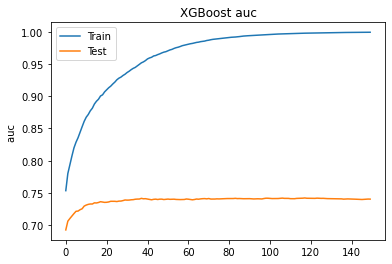

In [70]:
y_pred = xg_clf_fit.predict(val_X)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(val_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = xg_clf_fit.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('auc ')
pyplot.title('XGBoost auc')
pyplot.show()

# **training the model again**

after we checked overfitting we reduced the n_estimators and the learning_rate, trained a new model and worked on it from this point

In [16]:
""" XGB"""

xg_clf = xgb.XGBClassifier(max_depth = 6, learning_rate = 0.1, n_estimators = 17)
xg_clf.fit(train_X, train_y)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=17, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [111]:
xg_clf = xgb.XGBClassifier(max_depth = 6, learning_rate = 0.1, n_estimators = 17)
eval_set = [(train_X, train_y), (val_X, val_y)]
xg_clf.fit(train_X, train_y, eval_metric="auc",
        eval_set=eval_set)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-auc:0.75281	validation_1-auc:0.69225
[1]	validation_0-auc:0.76815	validation_1-auc:0.70110
[2]	validation_0-auc:0.77326	validation_1-auc:0.70310
[3]	validation_0-auc:0.78329	validation_1-auc:0.70831
[4]	validation_0-auc:0.79072	validation_1-auc:0.70975
[5]	validation_0-auc:0.79499	validation_1-auc:0.71170
[6]	validation_0-auc:0.79887	validation_1-auc:0.71308
[7]	validation_0-auc:0.80194	validation_1-auc:0.71257
[8]	validation_0-auc:0.80673	validation_1-auc:0.71316
[9]	validation_0-auc:0.81050	validation_1-auc:0.71464
[10]	validation_0-auc:0.81452	validation_1-auc:0.71694
[11]	validation_0-auc:0.81824	validation_1-auc:0.71823
[12]	validation_0-auc:0.82246	validation_1-auc:0.71977
[13]	validation_0-auc:0.82636	validation_1-auc:0.72124
[14]	validation_0-auc:0.82953	validation_1-auc:0.72215
[15]	validation_0-auc:0.83209	validation_1-auc:0.72321
[16]	validation_0-auc:0.83574	validation_1-auc:0.72425


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=17, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

Accuracy: 56.43%


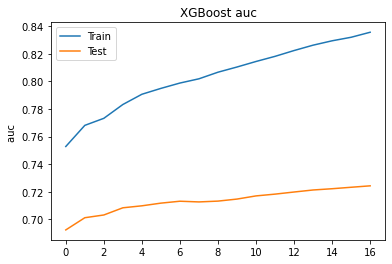

In [113]:
y_pred = xg_clf.predict(val_X)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(val_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = xg_clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('auc ')
pyplot.title('XGBoost auc')
pyplot.show()

### **Model self-Evaluation**

---



In [72]:
xg_clf_y = xg_clf.predict(val_X)
a8 = accuracy_score(val_y, xg_clf_y)
print("The Accuracy of Xgboost esstimator is ", a8)

The Accuracy of Xgboost esstimator is  0.5643333333333334


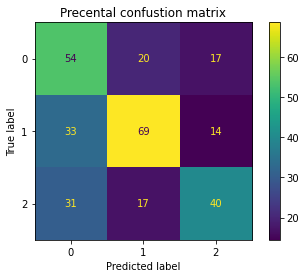

In [73]:
cm=confusion_matrix(val_y,xg_clf_y)
cm_sum = np.sum(cm, axis=1)
# cm_perc = cm /  cm_sum.astype(float) * 100
# cm_perc_round = np.round(cm_perc, decimals=2)
cm=confusion_matrix(val_y,xg_clf_y)
cm_perc = cm /  cm_sum.astype(float) * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_perc)
disp.plot()
plt.title("Precental confustion matrix")
plt.grid(visible=False)
plt.show()

### SHAP

In [20]:
import shap

In [21]:
explainer = shap.Explainer(xg_clf)
shap_values = explainer.shap_values(val_X)



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


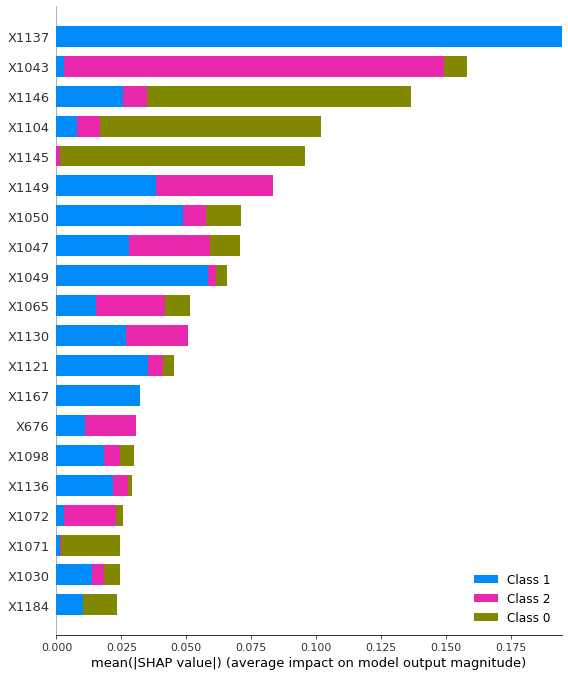

In [22]:
shap.summary_plot(shap_values,val_X)

while examining the SHAP summary plot we see that the features that influenced the most the 3 classes are:

-X1043

-X1146

-X1104

-X1050

-X1149

with the feature X1137 affecting only class 1

to better understand the influence of the feature on each class alone we will saperate the graphes 

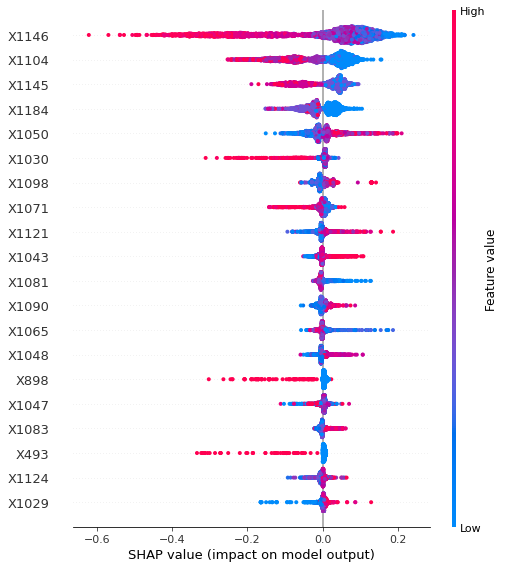

In [81]:
shap.summary_plot(shap_values[0], val_X)

For class 0, or inactive prediction, lower values of feature X1146, X1145, X1184 as well as X1104 inceased the prediction, and had impact on the model. However, higher values in feature X1050 and X1043 among other features has shown inceased prediction value.

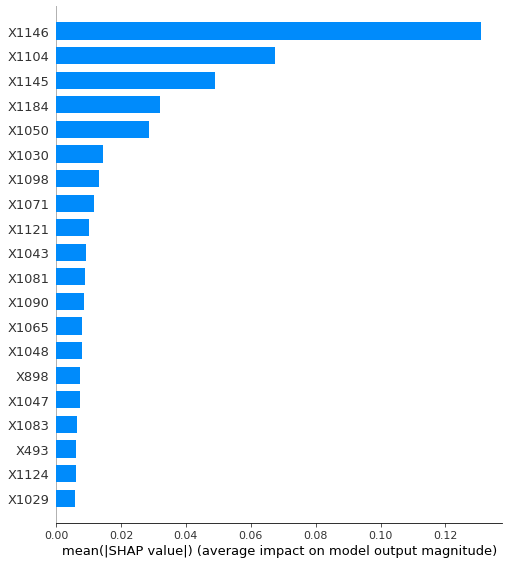

In [82]:
shap.summary_plot(shap_values[0], features=val_X, feature_names=val_X.columns, plot_type='bar')

Feature X1146 has the strongest influence on the model classification for class 0
the higher the value the less the impact on the model and vise versa,i.e there is negative association between 
it's value and the impact on the model. Nonetheless, no direction is presented here.

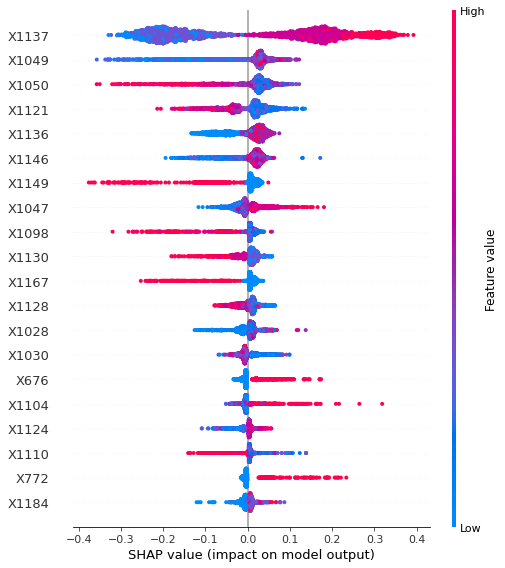

In [83]:
shap.summary_plot(shap_values[1], val_X)

For class 1, or Active prediction, higher values of feature X1137, X1047 as well as X1049 has shown higher prediction, i.e. they are positivly associated(and vise versa). Yet, higher values of X1050 and X1121 decreased the prediction, that is to say negetivly associated.

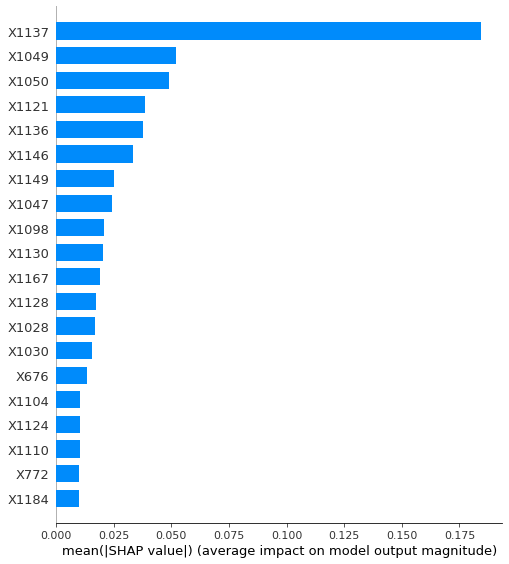

In [84]:
shap.summary_plot(shap_values[1], features=val_X, feature_names=val_X.columns, plot_type='bar')

feature X1137 has the strongest influence on the model classification on class 1 (as the previus plot shows also)
the higher it's value the greater the impact on the model ,i.e there is positive association between 
it's value and the impact on the model. 

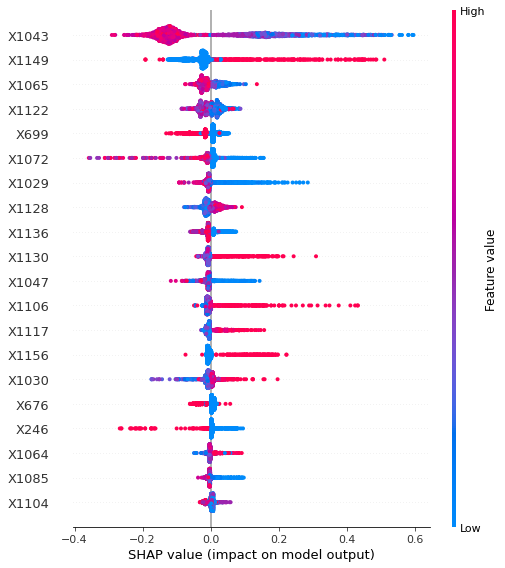

In [85]:
shap.summary_plot(shap_values[2], val_X)

For class 2, or Unknown prediction, higher values of some features like X1149 are mostly positvivly associated with greater impact on the model. Yet, there are multiple features, for instance X1043, X1029 which has shown higher prediction associated with lower values in the features themself, that is to say negetivly associated.

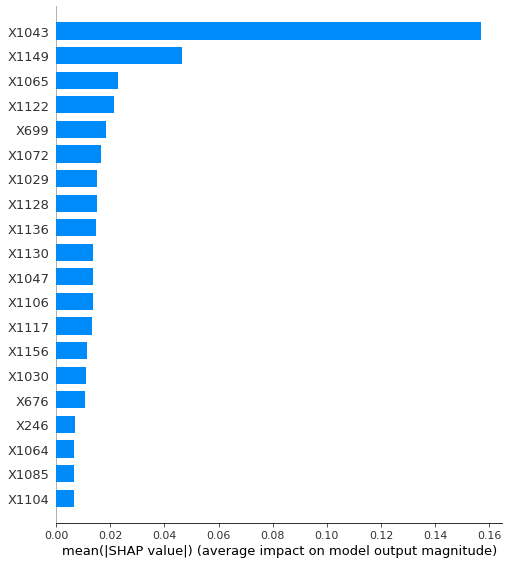

In [86]:
shap.summary_plot(shap_values[2], features=val_X, feature_names=val_X.columns, plot_type='bar')

For class2, the same interpertation (yet here no directionalty) can be driven for X1043, the feature with the strongest impact on prediting class 2.

# **Class 0-shap dependency_plot**

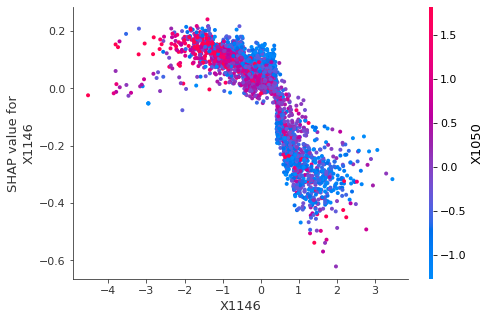

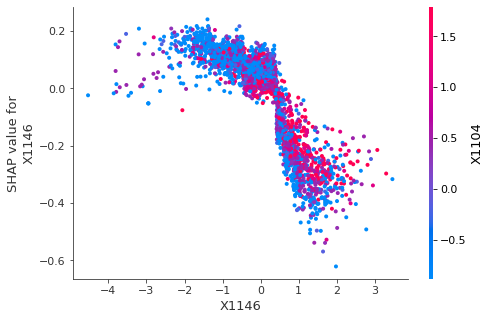

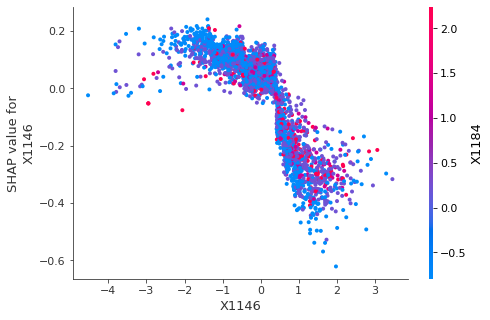

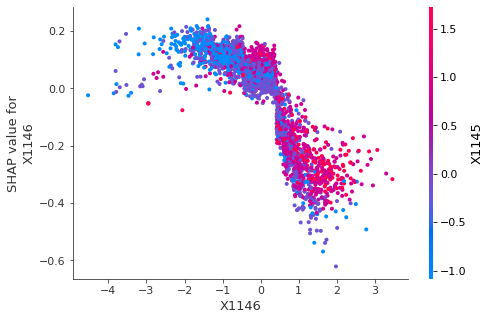

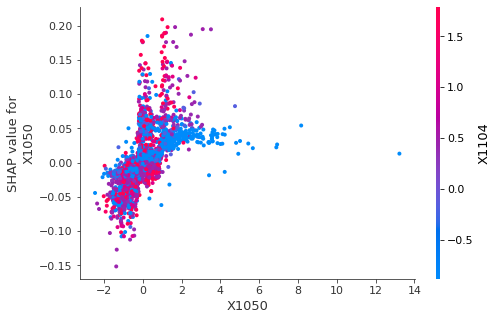

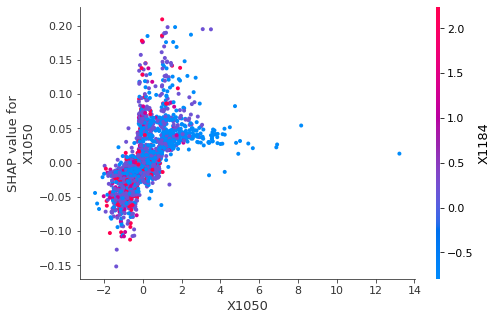

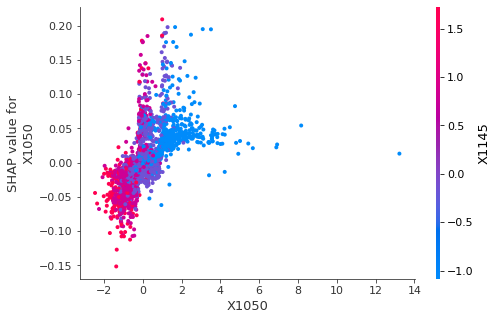

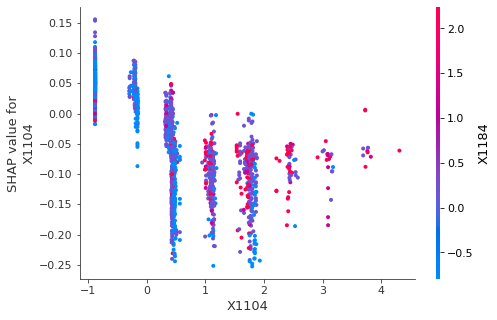

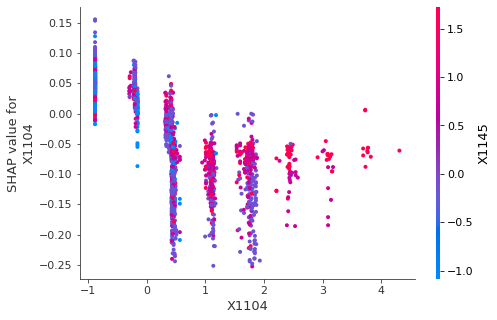

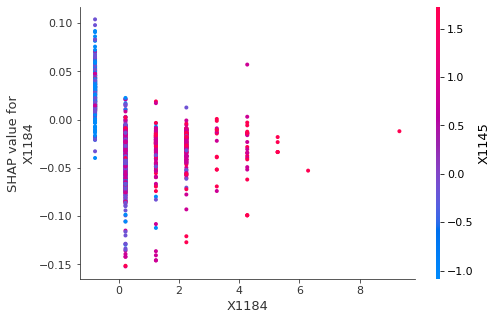

In [108]:
shap.dependence_plot('X1146', shap_values[0], val_X, interaction_index='X1050')
shap.dependence_plot('X1146', shap_values[0], val_X, interaction_index='X1104')
shap.dependence_plot('X1146', shap_values[0], val_X, interaction_index='X1184')
shap.dependence_plot('X1146', shap_values[0], val_X, interaction_index='X1145')


shap.dependence_plot('X1050', shap_values[0], val_X, interaction_index='X1104')
shap.dependence_plot('X1050', shap_values[0], val_X, interaction_index='X1184')
shap.dependence_plot('X1050', shap_values[0], val_X, interaction_index='X1145')


shap.dependence_plot('X1104', shap_values[0], val_X, interaction_index='X1184')
shap.dependence_plot('X1104', shap_values[0], val_X, interaction_index='X1145')


shap.dependence_plot('X1184', shap_values[0], val_X, interaction_index='X1145')

for class 0, we will interpate the relatipship between X1146 and X1050. as can be seen, the  primary trend is downward. the values of X1050 and 
X1146 are negativly correlated. the spread of the data indicates for an interaction with other features.

# **Class 1-shap dependency_plot**

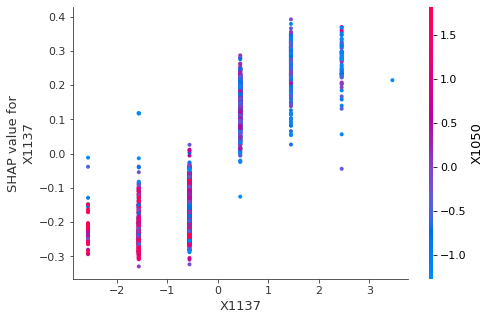

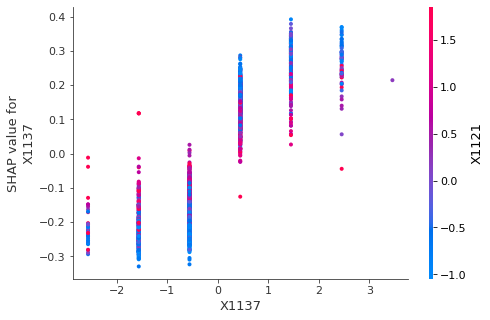

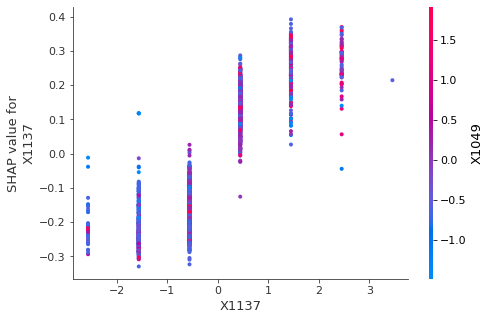

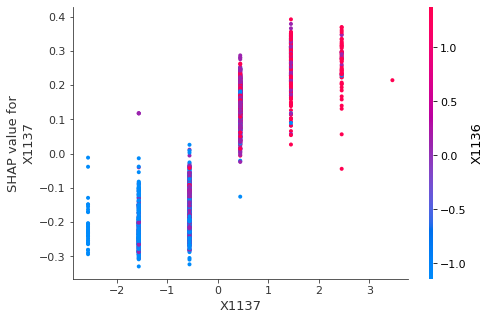

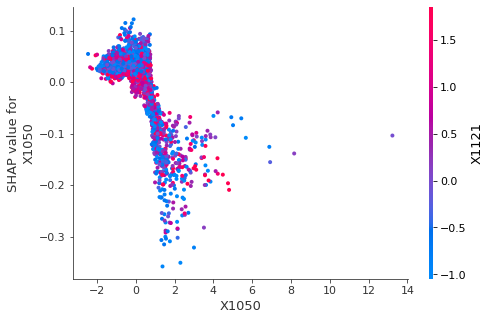

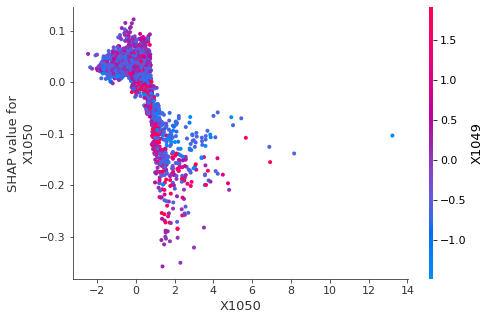

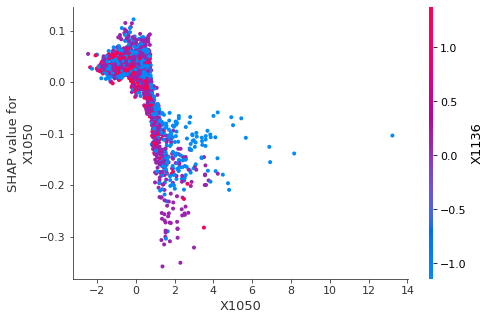

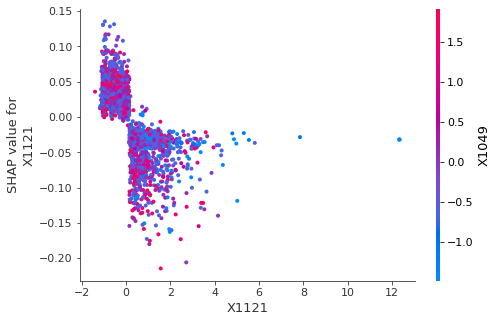

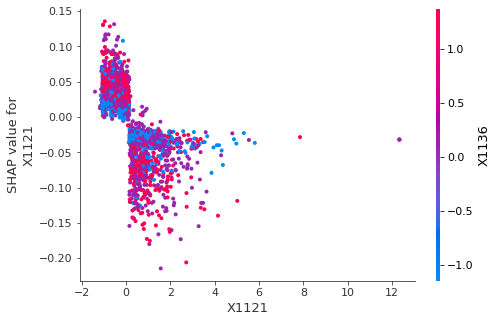

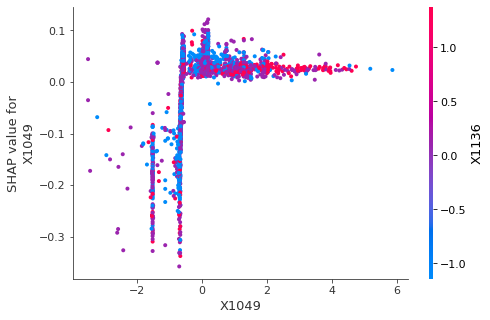

In [109]:


shap.dependence_plot('X1137', shap_values[1], val_X, interaction_index='X1050')
shap.dependence_plot('X1137', shap_values[1], val_X, interaction_index='X1121')
shap.dependence_plot('X1137', shap_values[1], val_X, interaction_index='X1049')
shap.dependence_plot('X1137', shap_values[1], val_X, interaction_index='X1136')


shap.dependence_plot('X1050', shap_values[1], val_X, interaction_index='X1121')
shap.dependence_plot('X1050', shap_values[1], val_X, interaction_index='X1049')
shap.dependence_plot('X1050', shap_values[1], val_X, interaction_index='X1136')


shap.dependence_plot('X1121', shap_values[1], val_X, interaction_index='X1049')
shap.dependence_plot('X1121', shap_values[1], val_X, interaction_index='X1136')


shap.dependence_plot('X1049', shap_values[1], val_X, interaction_index='X1136')

for class 1, we will interpetate the dependency between X1137 and X1136 features. as can be seen, the  primary trend is upward. lower values in X1030 are correalted with lower values of X1050 and lower prediction (and vise versa). the data is scattered, as it indicates for an interaction with other features.

# **Class 2-shap dependency_plot**

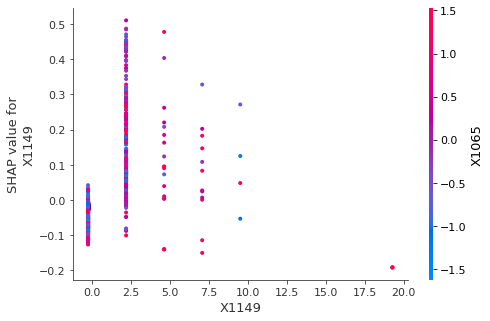

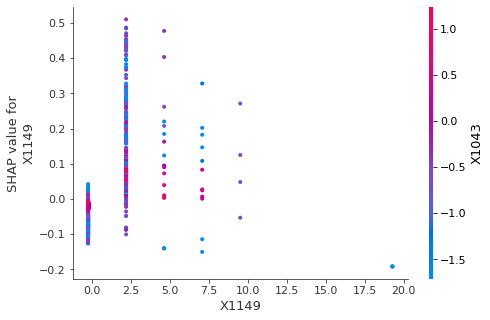

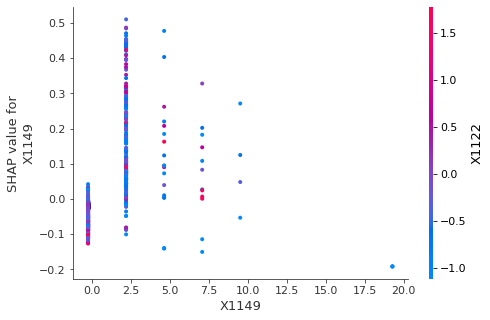

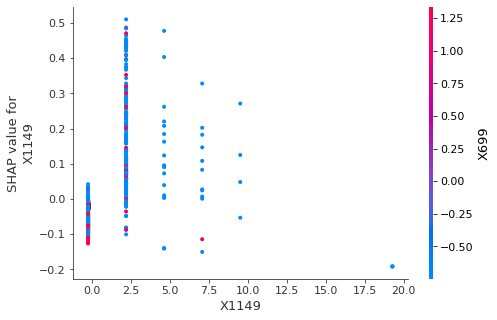

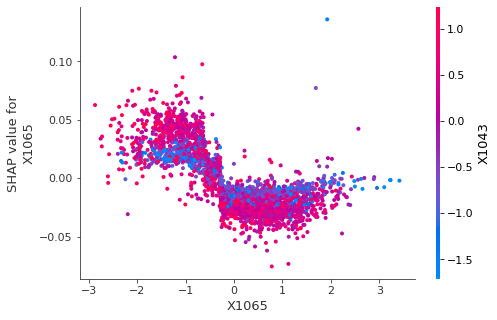

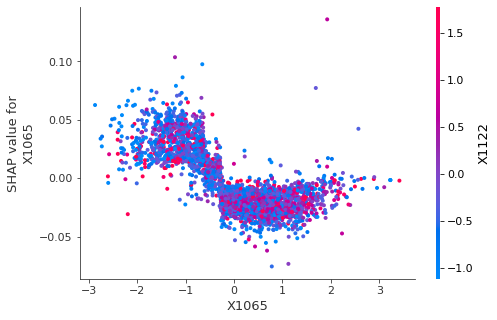

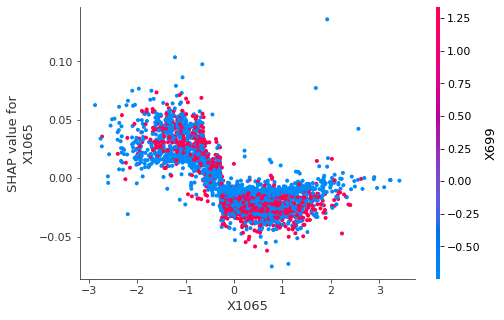

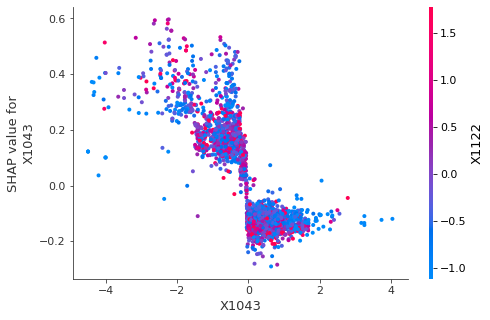

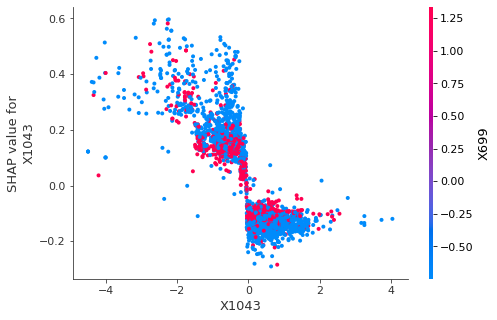

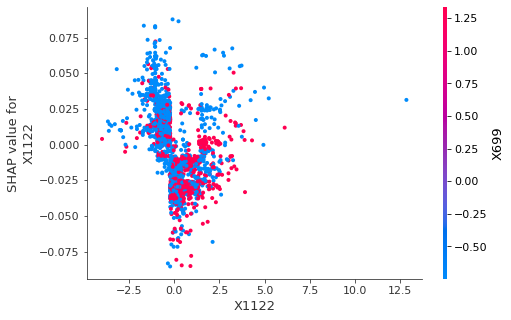

In [110]:


shap.dependence_plot('X1149', shap_values[2], val_X, interaction_index='X1065')
shap.dependence_plot('X1149', shap_values[2], val_X, interaction_index='X1043')
shap.dependence_plot('X1149', shap_values[2], val_X, interaction_index='X1122')
shap.dependence_plot('X1149', shap_values[2], val_X, interaction_index='X699')


shap.dependence_plot('X1065', shap_values[2], val_X, interaction_index='X1043')
shap.dependence_plot('X1065', shap_values[2], val_X, interaction_index='X1122')
shap.dependence_plot('X1065', shap_values[2], val_X, interaction_index='X699')


shap.dependence_plot('X1043', shap_values[2], val_X, interaction_index='X1122')
shap.dependence_plot('X1043', shap_values[2], val_X, interaction_index='X699')


shap.dependence_plot('X1122', shap_values[2], val_X, interaction_index='X699')

for class 2, we will interpate the relatipship between X699 and X1149. as can be seen, lower values in both features are associated with each other and with higher impact on the model. the data is scattered as it indicates for an interaction with other features, these features are slightly affected by such interactions, if found.

### **Final model evaluation**

---



XGB accuracy score with  classifier : 0.6629686304514154
ROC:
0.8376363719760214


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

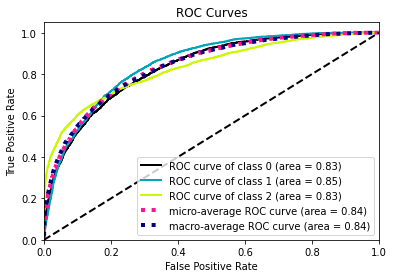

In [25]:
y_pred=xg_clf.predict(train_X)
y_pred_proba=xg_clf.predict_proba(train_X)
print('{Model_name} accuracy score with  classifier : {score}'. format(Model_name="XGB",score=accuracy_score(train_y, y_pred)))
print("ROC:")
print(metrics.roc_auc_score(train_y, y_pred_proba,multi_class="ovr"))
skplt.metrics.plot_roc(train_y,y_pred_proba)

AUC-ROC plot shows that our model is better at prediction of class 1 then 2 and then 0 (with 0.77, 0.72, and 0.69 respectivly for the validation data- upper plot of the ROC-AUC ). This plot demonstrate the goodness of the prediction. i.e the sensitivty and performance of the model. 

### **Send to prediction**

---


---




In [27]:
preds = xg_clf.predict(test_data)
#preds=pd.DataFrame(y_pred)
preds=pd.DataFrame(preds)
new_preds = preds.copy()
new_preds.insert(0,"ID", id_)
new_preds.rename(columns={0: "y_pred"},inplace=True)

In [106]:
new_preds.to_csv("XGboost_oversampled_final_u.csv", index=False)